In [83]:
import numpy as np
from datetime import datetime
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import xarray as xr
import contextily as ctx
import shapely
import pint_xarray

In [3]:
snotel = xr.open_dataset('data/snotel/snotel_hourly_1980_2024.zarr')
usgs = xr.open_dataset('data/stream/usgs_instantaneous_1980_2024.zarr')

/Users/jesse/projects/cewa568/.pixi/envs/default/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/cewa568/.pixi/envs/default/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


In [39]:
# Beaver Creek  Snotel
# <POINT Z (-120.99 48.528 4310)>

# Thunder Basin Snotel
# <POINT Z (-121.256 48.879 3630)>

# Thunder Creek USGS
# POINT Z (-121.07290 48.67263 1220.00000)

# Beaver Creek USGS
# POINT Z (-121.07343 48.77759 1610.23000)

beaver_creek_snotel_point = shapely.geometry.Point(-120.99, 48.528, 4310)
thunder_basin_snotel_point = shapely.geometry.Point(-121.256, 48.879, 3630)
thunder_creek_usgs_point = shapely.geometry.Point(-121.07290, 48.67263, 1220.00000)
beaver_creek_usgs_point = shapely.geometry.Point(-121.07343, 48.77759, 1610.23000)
snotel_points = [beaver_creek_snotel_point, thunder_basin_snotel_point]
usgs_points = [thunder_creek_usgs_point, beaver_creek_usgs_point]
snotel_points = shapely.multipoints(snotel_points)
usgs_points = shapely.multipoints(usgs_points)

In [40]:
usgs


<xarray.Dataset> Size: 27MB
Dimensions:    (date: 1134647, site: 2)
Coordinates:
  * date       (date) datetime64[ns] 9MB 1989-10-01T07:15:00 ... 2024-01-02T0...
  * site       (site) object 16B '12172000' '12175500'
Data variables:
    DISCHARGE  (date, site) float64 18MB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [41]:
snotel

<xarray.Dataset> Size: 16MB
Dimensions:                    (date: 218948, site: 2)
Coordinates:
  * date                       (date) datetime64[ns] 2MB 1987-10-22T06:00:00 ...
  * site                       (site) object 16B '817:WA:SNTL' '990:WA:SNTL'
Data variables:
    ACCUMULATED PRECIPITATION  (date, site) float64 4MB ...
    SWE                        (date, site) float64 4MB ...
    AIR TEMP                   (date, site) float64 4MB ...
    SNOWDEPTH                  (date, site) float64 4MB ...
Attributes:
    Description:  Snotel Data
    Date Range:   1980-2024
    Sites:        Thunder Basin, Beaver Creek
    Frequency:    Hourly

Text(-121.256, 48.879, 'Big Beaver Pass Snotel')

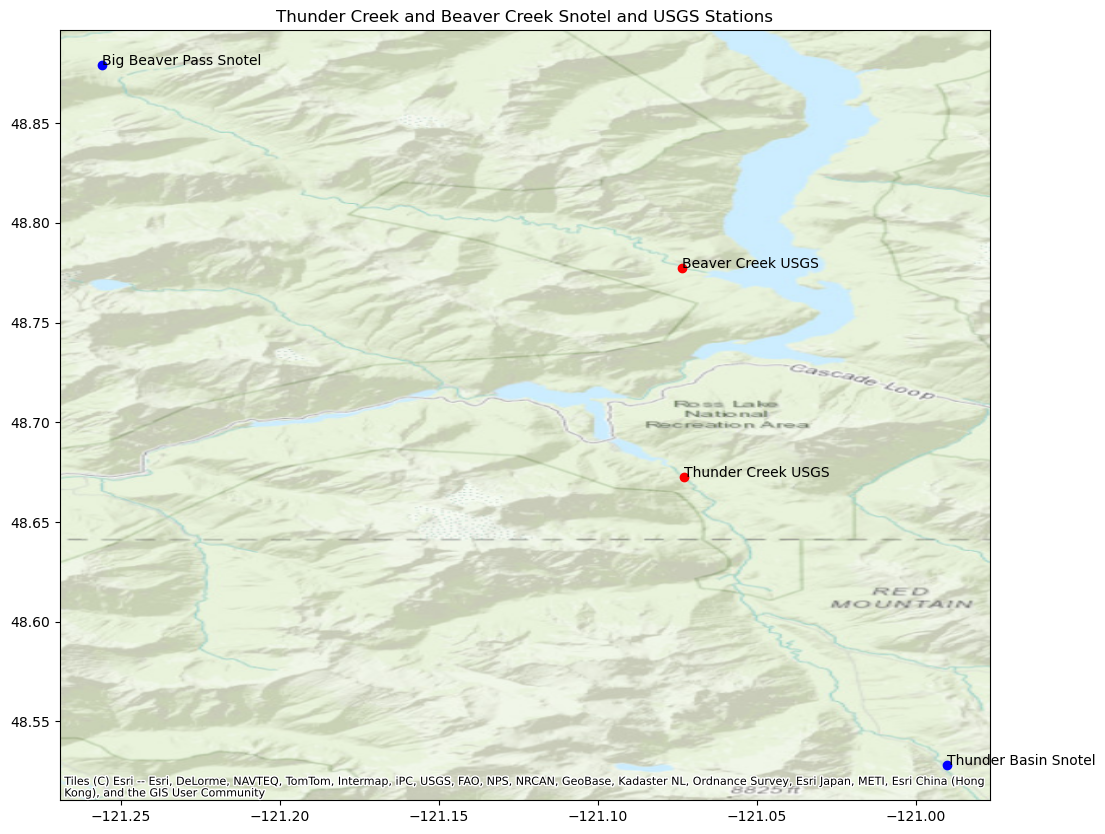

In [49]:
import shapely.plotting

skagit_gdf = gpd.read_file('./data/gis/SkagitBoundary.json')
fig, ax = plt.subplots(figsize=(12, 10))
shapely.plotting.plot_points(usgs_points, ax, color='red')
shapely.plotting.plot_points(snotel_points, ax, color='blue')
ctx.add_basemap(ax, crs='EPSG:8246', source=ctx.providers.Esri.WorldTopoMap)
ax.set_title('Thunder Creek and Beaver Creek Snotel and USGS Stations')
ax.text(-121.07290, 48.67263, 'Thunder Creek USGS', fontsize=10)
ax.text(-121.07343, 48.77759, 'Beaver Creek USGS', fontsize=10)
ax.text(-120.99, 48.528, 'Thunder Basin Snotel', fontsize=10)
ax.text(-121.256, 48.879, 'Big Beaver Pass Snotel', fontsize=10)

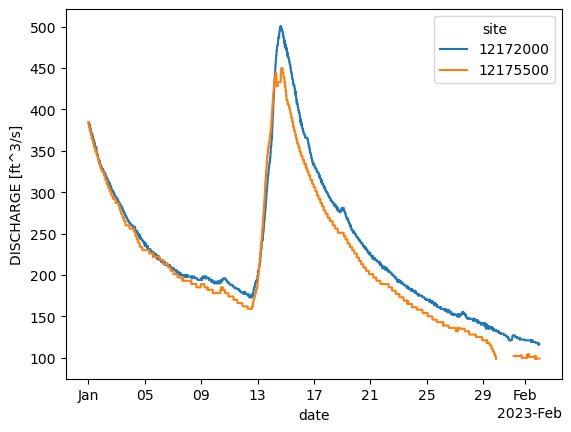

In [86]:
usgs_winter_2023 = usgs.sel(date=slice('2023-01-01', '2023-02-01'))
usgs_winter_2023.DISCHARGE.plot.line(x='date', hue='site')
snotel_winter_2023 = snotel.sel(date=slice('2023-01-01', '2023-02-01'))
# usgs_winter_2024
# usgs

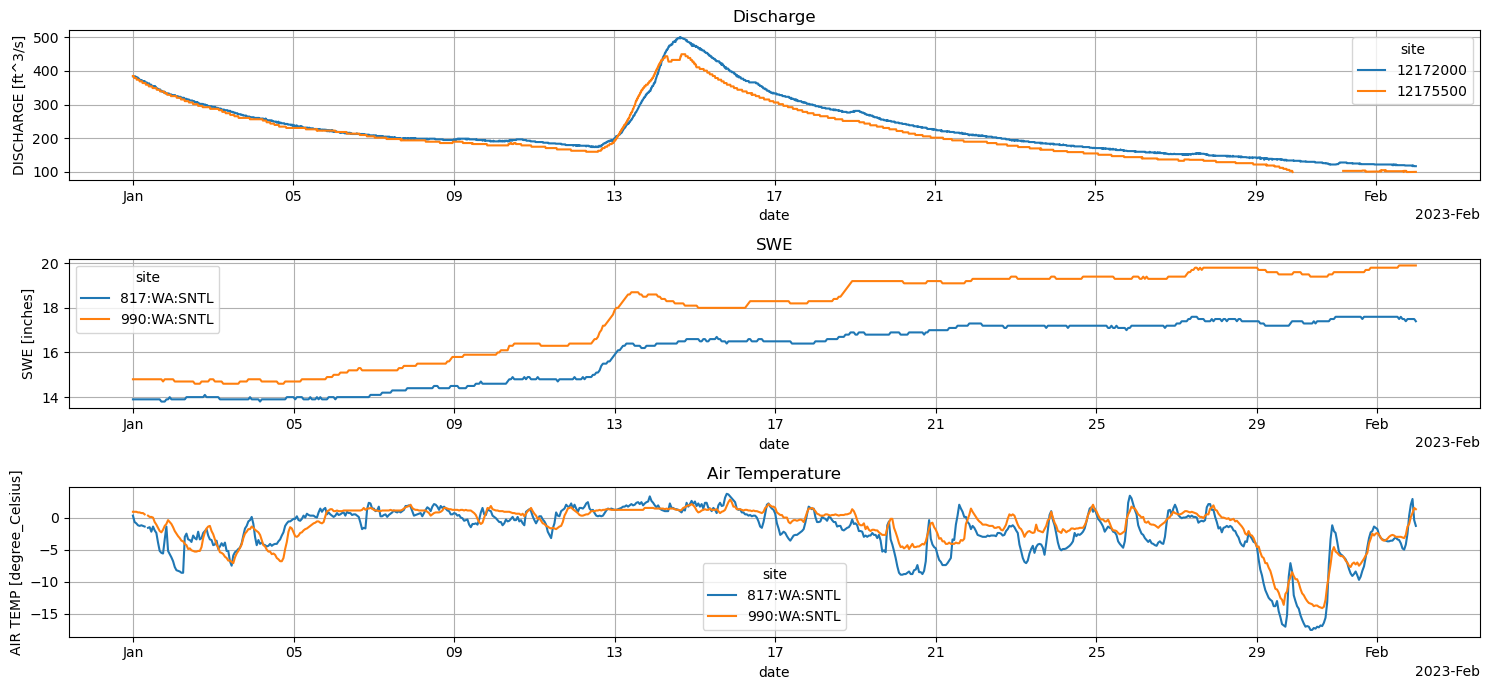

In [89]:
# usgs = usgs.assign_coords(site=usgs.site.astype(str))

# Calculate the rolling median and standard deviation
# rolling_median = usgs_winter_2023['DISCHARGE'].rolling(date=24*7, center=True).median()
# rolling_std = usgs_winter_2023['DISCHARGE'].rolling(date=24*7, center=True).std()

# # Identify spikes
# spikes = usgs_winter_2023['DISCHARGE'] > (rolling_median + 2 * rolling_std)

# # Plot the discharge and spikes
fig, ax = plt.subplots(3,1,figsize=(15, 7))
usgs_winter_2023['DISCHARGE'].plot.line(x='date', hue='site', ax=ax[0])
ax[0].grid(True)
ax[0].set_title('Discharge')
snotel_winter_2023['SWE'].plot.line(x='date', hue='site', ax=ax[1])
ax[1].grid(True)
ax[1].set_title('SWE')
snotel_winter_2023['AIR TEMP'].pint.quantify('degF').pint.to('degC').plot.line(x='date', hue='site', ax=ax[2])
ax[2].grid(True)
ax[2].set_title('Air Temperature')
fig.tight_layout()
# ax.scatter(pd.to_datetime(usgs['DISCHARGE'].where(spikes).date), usgs['DISCHARGE'].where(spikes), color='red', label='Spikes')
# ax.set_title('Discharge with Spikes Greater Than 2 Standard Deviations Above Rolling Median')
# ax.set_xlabel('Date')
# ax.set_ylabel('Discharge')
# ax.legend()
# plt.show()